In [1]:
import numpy as np
np.set_printoptions(precision=4)
from pathlib import Path
import mujoco
import matplotlib.pyplot as plt
import logging
from scipy.spatial import ConvexHull, convex_hull_plot_2d, QhullError
import itertools
import pandas as pd
import cvxopt as cvx

In [2]:
def draw_images(cloth, axis, angle):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, camera in zip(axs, ['robot0_robotview', 'sideview', 'robot0_eye_in_hand']):
        contact_image = Path(contact_data_dir) / f"{cloth}_{axis}_{angle}_{camera}.png"
        ax.imshow(plt.imread(contact_image))
        ax.set_title(camera)
    plt.show()

In [3]:
contact_data_dir = "04042024-131547"
cloth_name, axis, angle = 0, "x", -30
file_path = Path(contact_data_dir) / f"{cloth_name}_{axis}_{angle}.npy"
contacts_0 = np.load(file_path,allow_pickle='TRUE').item()
contacts_0

{'dim': 4,
 'pos': array([[ 0.1724, -0.117 ,  0.843 ],
        [ 0.1496, -0.0832,  0.8177]]),
 'geom': array([[83, 73],
        [83, 76]], dtype=int32),
 'forces': array([[-6.2432e-01, -7.4708e-01, -6.8948e-01, -5.0913e-01, -3.8638e-01,
         -4.4397e-01,  6.2908e-01,  7.7807e-01,  7.7372e-01,  6.2039e-01,
          4.7140e-01,  4.7575e-01],
        [ 7.8489e-01,  6.2814e-01,  5.5573e-01,  6.4008e-01,  7.9683e-01,
          8.6923e-01, -7.8565e-01, -6.6189e-01, -6.5646e-01, -7.7479e-01,
         -8.9854e-01, -9.0397e-01],
        [-2.1018e-01, -3.1196e-01, -5.1553e-01, -6.1732e-01, -5.1553e-01,
         -3.1196e-01,  1.9240e-01,  8.0647e-02, -1.4285e-01, -2.5460e-01,
         -1.4285e-01,  8.0647e-02],
        [-1.3883e-02, -9.4576e-03, -5.6139e-03, -6.1954e-03, -1.0621e-02,
         -1.4464e-02,  7.4547e-04, -1.1848e-03, -6.1351e-03, -9.1552e-03,
         -7.2250e-03, -2.2746e-03],
        [-8.9208e-03, -9.5116e-03, -4.3990e-03,  1.3044e-03,  1.8952e-03,
         -3.2174e-03, -2.14

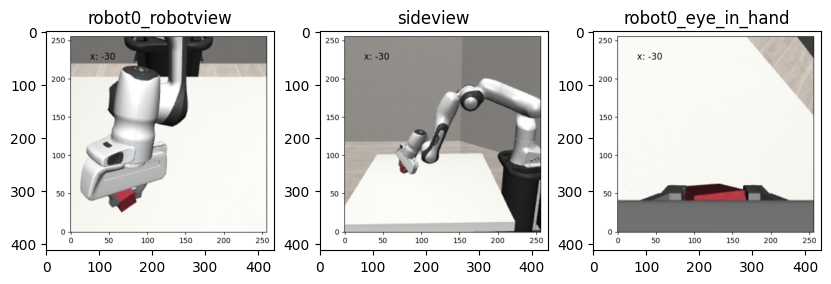

In [4]:
draw_images(cloth_name, axis, angle)

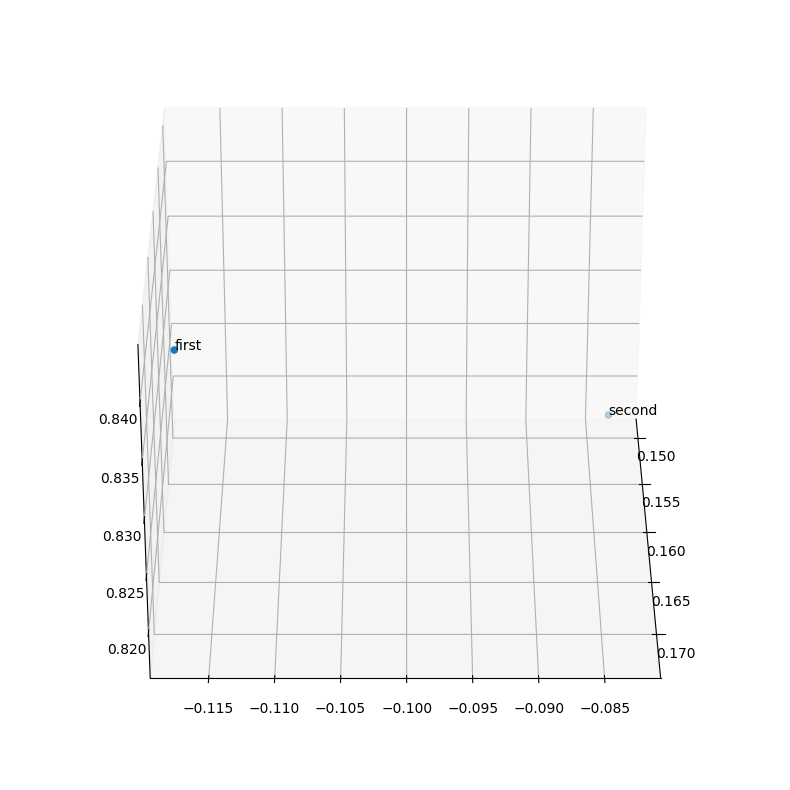

In [5]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 0, 0)
all_coordinates = contacts_0['pos']
ax.scatter(all_coordinates[:, 0], all_coordinates[:, 1], all_coordinates[:, 2])
ax.text(all_coordinates[0, 0], all_coordinates[0, 1], all_coordinates[0, 2], f"first")
ax.text(all_coordinates[1, 0], all_coordinates[1, 1], all_coordinates[1, 2], f"second")
plt.show()

Text(0.14955715471170877, -0.08321638218680491, 'second')

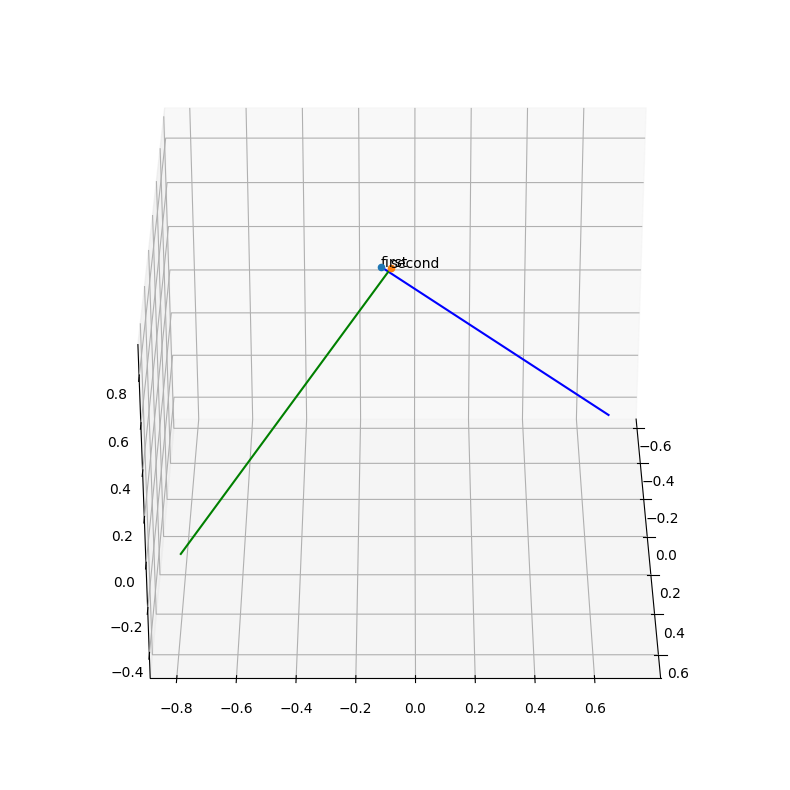

In [6]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 0, 0)
point_x, point_y, point_z = contacts_0['pos'][0]
normal_x, normal_y, normal_z = -(contacts_0['frame'][0][:3])
plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="blue")
ax.scatter(point_x, point_y, point_z)
# ax.text(point_x , point_y, point_z, f"first: {point_x:.2f}, {point_y:.2f}, {point_z:.2f}")
ax.text(point_x , point_y, point_z, f"first")


point_x, point_y, point_z = contacts_0['pos'][1]
normal_x, normal_y, normal_z = -(contacts_0['frame'][1][:3])
plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="green")
ax.scatter(point_x, point_y, point_z)
# ax.text(point_x , point_y, point_z, f"first: {point_x:.2f}, {point_y:.2f}, {point_z:.2f}")
ax.text(point_x , point_y, point_z, f"second")

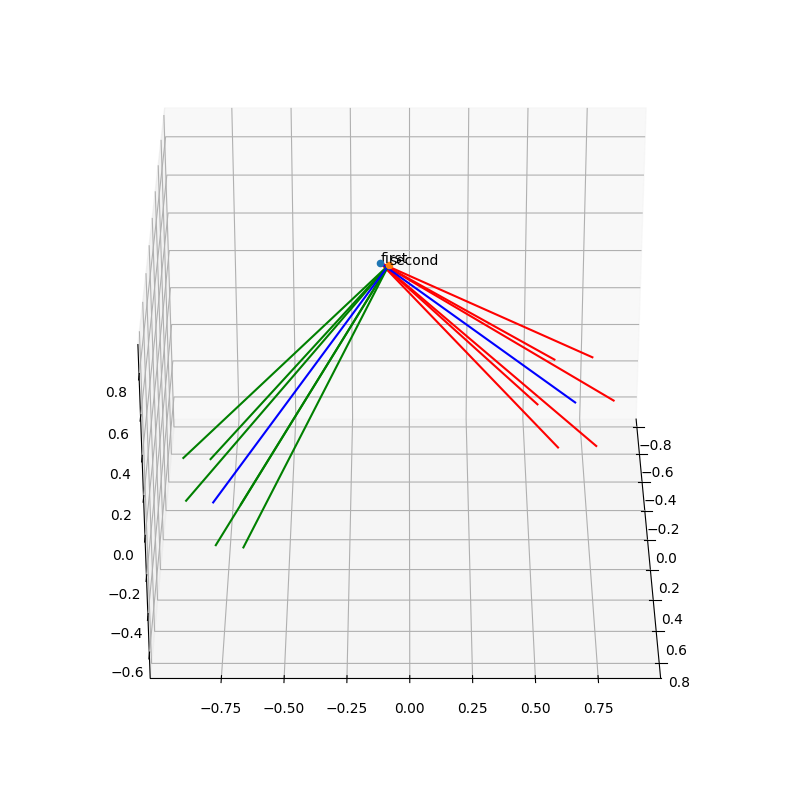

In [7]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
scale=1.0

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 0, 0)

point_x, point_y, point_z = contacts_0['pos'][0]
cone_support = contacts_0['forces'][:3, :6]
normal_x, normal_y, normal_z = -(contacts_0['frame'][0][:3])

for i in range(cone_support.shape[1]):
    dest = cone_support[:,i]
    plt.plot((point_x, dest[0]), (point_y, dest[1]), (point_z, dest[2]), color="red")

plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="blue")
ax.scatter(point_x, point_y, point_z)
# ax.text(point_x , point_y, point_z, f"first: {point_x:.2f}, {point_y:.2f}, {point_z:.2f}")
ax.text(point_x , point_y, point_z, f"first")

point_x, point_y, point_z = contacts_0['pos'][1]
cone_support = contacts_0['forces'][:3, 6:]
normal_x, normal_y, normal_z = -(contacts_0['frame'][1][:3])

for i in range(cone_support.shape[1]):
    dest = cone_support[:,i]
    plt.plot((point_x, dest[0]), (point_y, dest[1]), (point_z, dest[2]), color="green")

plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="blue")
ax.scatter(point_x, point_y, point_z)
# ax.text(point_x, point_y, point_z, f"second: {point_x:.2f}, {point_y:.2f}, {point_z:.2f}")
ax.text(point_x, point_y, point_z, f"second")

plt.show()

In [8]:
contacts_0['forces'].shape

(6, 12)

In [17]:
contacts_0['forces']

array([[-6.2432e-01, -7.4708e-01, -6.8948e-01, -5.0913e-01, -3.8638e-01,
        -4.4397e-01,  6.2908e-01,  7.7807e-01,  7.7372e-01,  6.2039e-01,
         4.7140e-01,  4.7575e-01],
       [ 7.8489e-01,  6.2814e-01,  5.5573e-01,  6.4008e-01,  7.9683e-01,
         8.6923e-01, -7.8565e-01, -6.6189e-01, -6.5646e-01, -7.7479e-01,
        -8.9854e-01, -9.0397e-01],
       [-2.1018e-01, -3.1196e-01, -5.1553e-01, -6.1732e-01, -5.1553e-01,
        -3.1196e-01,  1.9240e-01,  8.0647e-02, -1.4285e-01, -2.5460e-01,
        -1.4285e-01,  8.0647e-02],
       [-1.3883e-02, -9.4576e-03, -5.6139e-03, -6.1954e-03, -1.0621e-02,
        -1.4464e-02,  7.4547e-04, -1.1848e-03, -6.1351e-03, -9.1552e-03,
        -7.2250e-03, -2.2746e-03],
       [-8.9208e-03, -9.5116e-03, -4.3990e-03,  1.3044e-03,  1.8952e-03,
        -3.2174e-03, -2.1437e-03, -3.2143e-03, -3.9945e-03, -3.7041e-03,
        -2.6334e-03, -1.8533e-03],
       [ 7.9242e-03,  3.4972e-03,  2.7662e-03,  6.4622e-03,  1.0889e-02,
         1.1620e-02, -

In [16]:
np.linalg.matrix_rank(contacts_0['forces'][:3, :])

3

In [14]:
contacts_0['forces'][:,0]

array([-0.6243,  0.7849, -0.2102, -0.0139, -0.0089,  0.0079])

In [21]:
ConvexHull(contacts_0['forces'][:5, :].T).volume

1.2399697633584359e-06